In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

#imports
import torch
from hmpinn.utils.ml_utils import *
from hmpinn.plotting import *
from hmpinn.differential_operators.laplacian import Laplacian
from hmpinn.PDEs import *
from hmpinn.models import *

import seaborn as sns
#Setting theme
sns.set_theme(style="whitegrid")

def show_abs_error(ratio, pde, title):
    path = f"../simulation_studies/weakly_enforcing_BC/outputs/{ratio}_{pde}_tanh"
    plot_model_vs_analytical_error(path, title=f"{title} ratio={ratio}")

# Physics-informed Neural Networks for Harmonic Maps

**Ultimate Goal:** Solving PDEs in non-divergence form using physics-informed neural networks (PINNs)

**Potential applications:** Finding a diffeomorphism between a square and a exact geometry to help with mesh generation

## Stepping stones
- Implementation of PINNs for a simple Poisson problem ✔
- Solving Poisson problems with non constant diffusion coefficients ✔
- Finding approximate solution for scalar elliptic PDE in non-divergence form ✔
- Scalar quasi-linear PDE in non-divergence form

## Playing with PINNs

S. Wang, Sankaran, H. Wang and Perdikaris, _An Expert's Guide to Training Physics-informed Neural Networks_, 2023,

I chose 2 main models. They are both MLP with tanh activation function. The first model has hidden layers: [20, 20, 20, 20], while the second model has [64, 64, 64, 64, 64, 64]. I did perform some simulation to find the best model architectures and these were the best.

In [2]:
eigenfunction = EigenfunctionSourceDF()
model_small = ModelV0(eigenfunction, nodes_hidden_layers=[20, 20, 20, 20], has_embedding_layer=False)
model_small

ModelV0(
  (embedding_block): Sequential(
    (no_embedding): Identity()
  )
  (network): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (tanh_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (tanh_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (tanh_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (tanh_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [3]:
eigenfunction = EigenfunctionSourceDF()
model_big = ModelV0(eigenfunction, nodes_hidden_layers=[64, 64, 64, 64, 64, 64], has_embedding_layer=False)
model_big

ModelV0(
  (embedding_block): Sequential(
    (no_embedding): Identity()
  )
  (network): Sequential(
    (layer_0): Linear(in_features=2, out_features=64, bias=True)
    (tanh_0): Tanh()
    (layer_1): Linear(in_features=64, out_features=64, bias=True)
    (tanh_1): Tanh()
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (tanh_2): Tanh()
    (layer_3): Linear(in_features=64, out_features=64, bias=True)
    (tanh_3): Tanh()
    (layer_4): Linear(in_features=64, out_features=64, bias=True)
    (tanh_4): Tanh()
    (layer_5): Linear(in_features=64, out_features=64, bias=True)
    (tanh_5): Tanh()
    (layer_6): Linear(in_features=64, out_features=1, bias=True)
  )
)

### The Eigenfunction of the laplacian

I will try to solve the following poisson problem
\begin{equation}
\Delta u = f(x, y)
\end{equation}

with boundary conditions:

\begin{equation}
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0
\end{equation}

where

\begin{equation}
f(x, y) = -\sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

The analytical solution to this is
\begin{equation}
u(x, y) = \frac{1}{2 \pi^2} \sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

In [4]:
eigenfunction = EigenfunctionSourceDF()
model_1 = ModelV0(eigenfunction)
model_1.train()
train(model_1, n_epochs=100, optimizer_threshold=90, loss_BC_weight=0)
model_2 = ModelV0(eigenfunction, has_embedding_layer=False)
model_2.train()
train(model_2, n_epochs=100, optimizer_threshold=90, loss_BC_weight=0)
print("Done")

Using Cuda
Solving the PDE: EigenfunctionSourceDF(a=1, b=1, amplitude=1, backend=torch)


  0%|          | 0/90 [00:00<?, ?it/s]e:\ProgramFiles\envs\PINN_env\lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Using Cuda
Solving the PDE: EigenfunctionSourceDF(a=1, b=1, amplitude=1, backend=torch)


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

Done


In [5]:
x = torch.rand(5, 2, requires_grad=True)
model_1.eval()
print("Laplacian of the PINN:")
print(Laplacian()(model_1, x), "\n")
print("Laplacian of the analytical solution:")
print(Laplacian()(eigenfunction.u,x), "\n")

Laplacian of the PINN:
tensor([-0.1695, -0.1012, -0.4095, -0.4300, -0.1386], grad_fn=<AddBackward0>) 

Laplacian of the analytical solution:
tensor([-0.1845, -0.1188, -0.3961, -0.4227, -0.1463], grad_fn=<AddBackward0>) 



#### Without enforcing the boundary condition

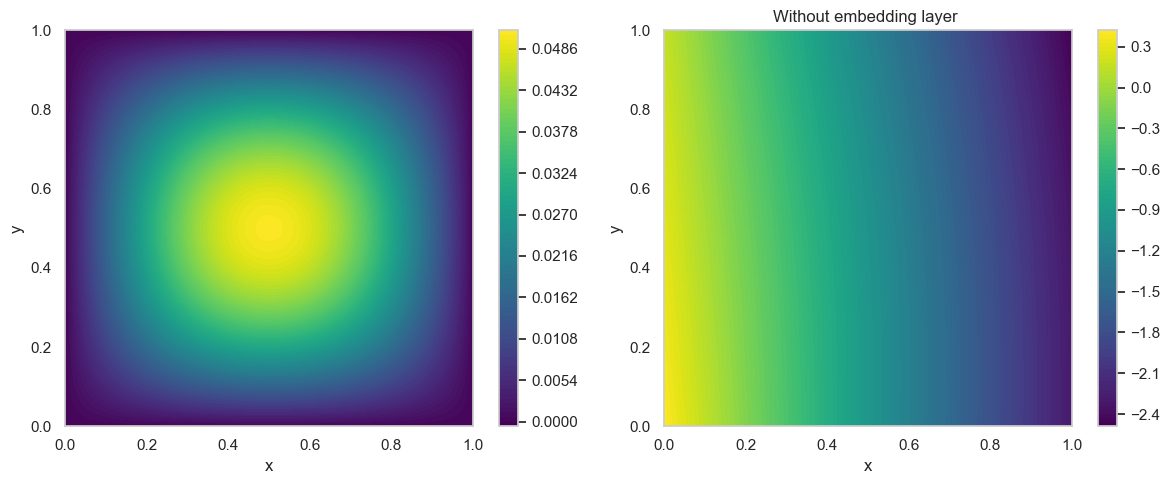

In [6]:
model_2.eval()
plot_model_vs_analytical_contour(model_2, title_model="Without embedding layer ")

#### Strongly enforcing the boundary condition

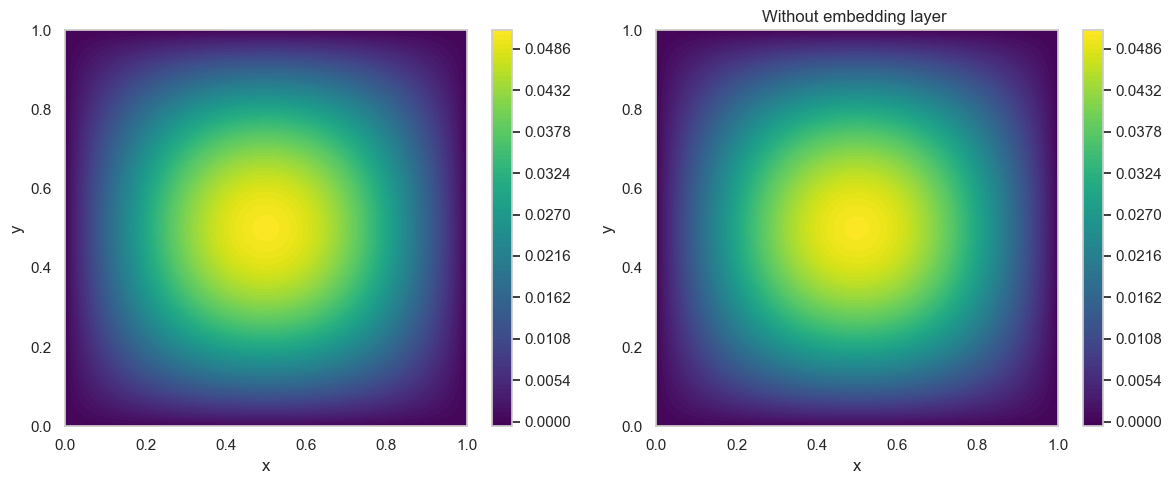

In [7]:
model_1.train()
plot_model_vs_analytical_contour(model_1, title_model="Without embedding layer ")

# A core isssue: the boundary condition

## First method: Strongly enforcing boundary conditions

Kast Mariella, and Jan S. Hesthaven, 2023, _Positional Embeddings for Solving PDEs with Evolutional Deep Neural Networks_

Let $ \phi _1, \dots, \phi_m$ be eigenfunctions of the laplacian with zero boundary condition on the unit square. Let $\Phi$ be a vector values function such that $\Phi_i(x, y) = \phi_i(x, y)$. Let $\hat{u}$ be the PINNs we have trained. Then
$$ B_{DC}\hat{u}(\Phi(x, y)) = B_{DC}\hat{u}(0, 0) = c \quad \text{for} \quad (x, y) \in \partial([0,1]^2)$$
If we have a constant boundary condition 
$$ u(x, y) = k \quad \text{for} \quad (x, y) \in \partial([0,1]^2) \quad k\in \mathbb{R}$$
then we can **strongly enforce this boundary condition** 
$$ \tilde{u}(x, y) = \hat{u}(\Phi(x, y)) - \hat{u}(0, 0) + k

So I tried to add an layer to the PINN that would act like $\Phi(x)$. 

e:\documents\epfl\semester project\hmpinn\hmpinn\plotting\plotting_errors.py:217: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y, res, cmap="YlOrRd", levels=levels_list, norm=LogNorm())


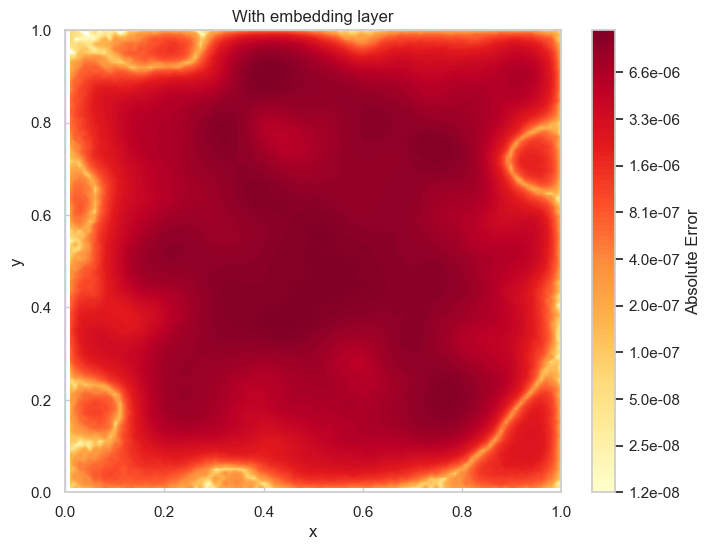

In [8]:
path_to_model_dir = "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000"
plot_model_vs_analytical_error(path_to_model_dir, title="With embedding layer")

## The problems

The PINN was very slow to train!

### The Eigenfunction of the laplacian

I will try to solve the following poisson problem
\begin{equation}
\Delta u = f(x, y)
\end{equation}

with boundary conditions:

\begin{equation}
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0
\end{equation}

where

\begin{equation}
f(x, y) = -\sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

The analytical solution to this is
\begin{equation}
u(x, y) = \frac{1}{2 \pi^2} \sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

### Training with the embedding layers

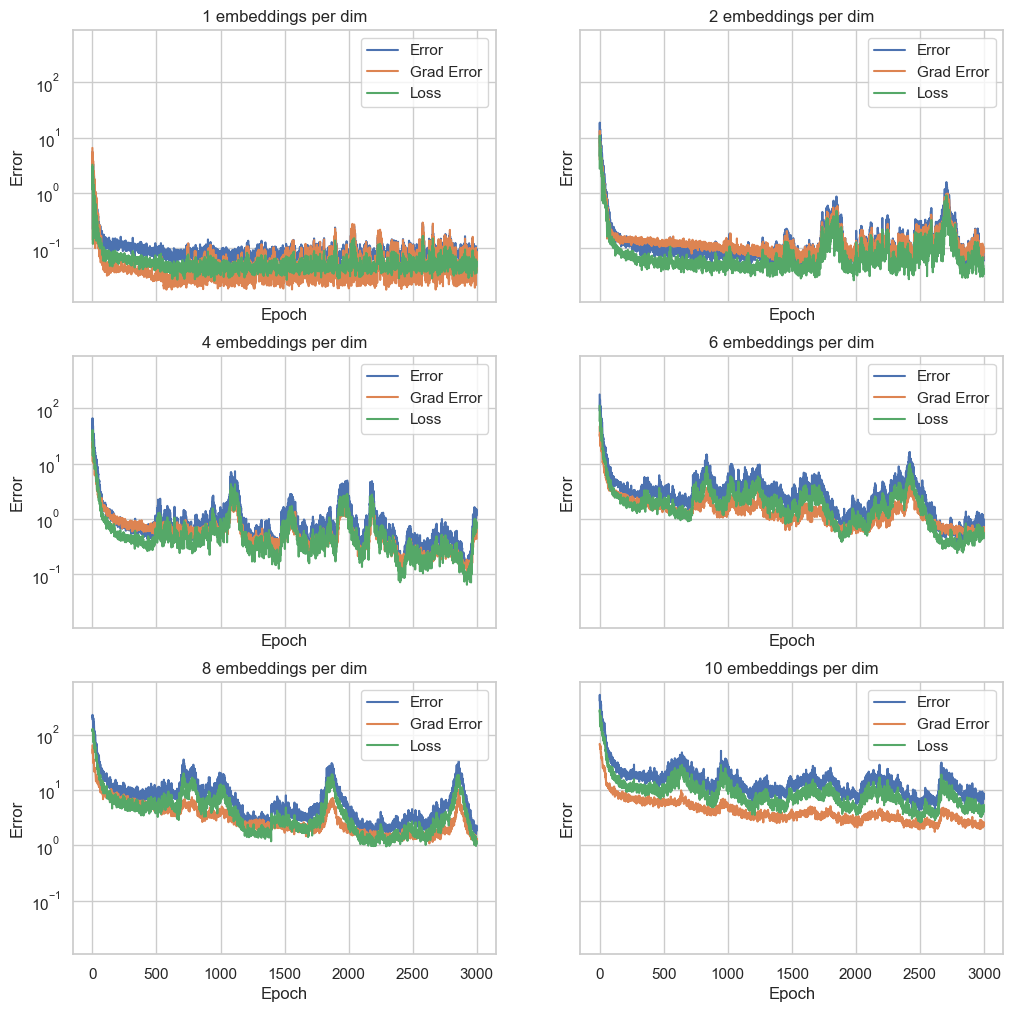

In [9]:
# All the paths for the embedding data
## I chose to use the batch size = 100 for this part
path_list = [
    "../simulation_studies/model_v0_simulation/outputs/100 batches_1 embeddings_per_dim",
    "../simulation_studies/model_v0_simulation/outputs/100 batches_2 embeddings_per_dim",
    "../simulation_studies/model_v0_simulation/outputs/100 batches_4 embeddings_per_dim",
    "../simulation_studies/model_v0_simulation/outputs/100 batches_6 embeddings_per_dim",
    "../simulation_studies/model_v0_simulation/outputs/100 batches_8 embeddings_per_dim",
    "../simulation_studies/model_v0_simulation/outputs/100 batches_10 embeddings_per_dim"
]
embeddings_per_dim_list = ["1 embeddings per dim" , "2 embeddings per dim" , 
                           "4 embeddings per dim" , "6 embeddings per dim" , 
                           "8 embeddings per dim" , "10 embeddings per dim"]

plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=embeddings_per_dim_list)

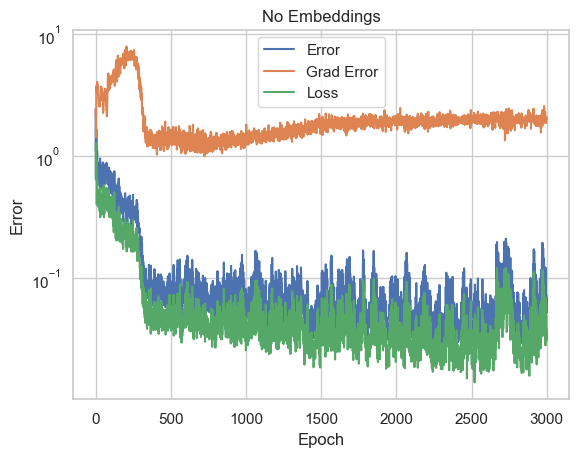

In [10]:
path = "../simulation_studies/model_v0_simulation/outputs/100 batches_0 embeddings_per_dim"
title = "No Embeddings"
plot_errors_from_path(path, title=title)

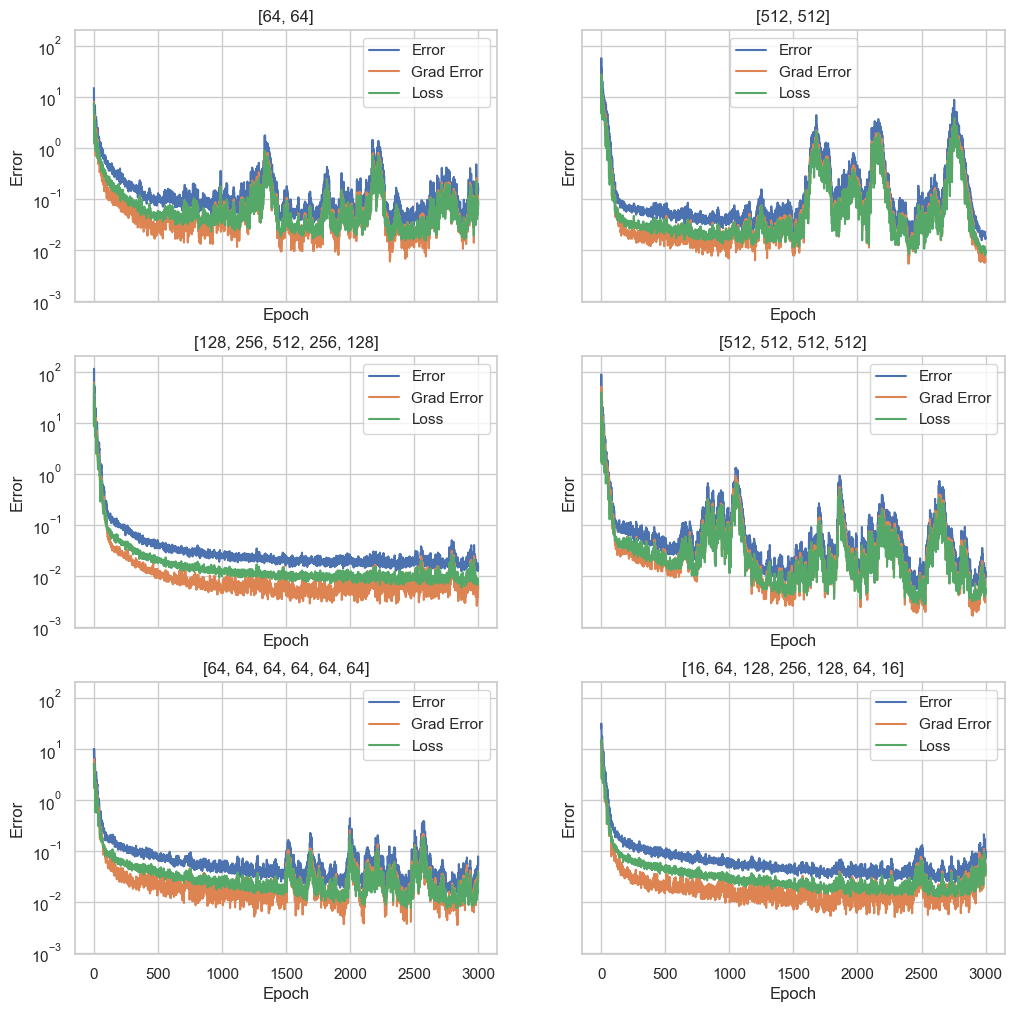

In [11]:
path_list = [
    "../simulation_studies/model_v0_simulation/outputs/eigenfunc/model_[64, 64]",
    "../simulation_studies/model_v0_simulation/outputs/eigenfunc/model_[512, 512]",
    "../simulation_studies/model_v0_simulation/outputs/eigenfunc/model_[128, 256, 512, 256, 128]",
    "../simulation_studies/model_v0_simulation/outputs/eigenfunc/model_[512, 512, 512, 512]",
    "../simulation_studies/model_v0_simulation/outputs/eigenfunc/model_[64, 64, 64, 64, 64, 64]",
    "../simulation_studies/model_v0_simulation/outputs/eigenfunc/model_[16, 64, 128, 256, 128, 64, 16]",
]

hidden_layers_list = ["[64, 64]", "[512, 512]",
                        "[128, 256, 512, 256, 128]", "[512, 512, 512, 512]",
                        "[64, 64, 64, 64, 64, 64]",
                        "[16, 64, 128, 256, 128, 64, 16]"]
plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=hidden_layers_list)

#### Fix 1

To help with the high fluctuations I added gradient clipping to the training function.

#### Fix 2

Kiyania, Shuklaa, Urbàn, Darbona, Karniadakisa, _Which Optimizer Works Best for Physics-Informed Neural Networks and Kolmogorov-Arnold Networks?_, 2025

This paper suggests to use second order optimizers. In light of this I chose to start with a first order optimizer and then switch to LBFGS half way through the training

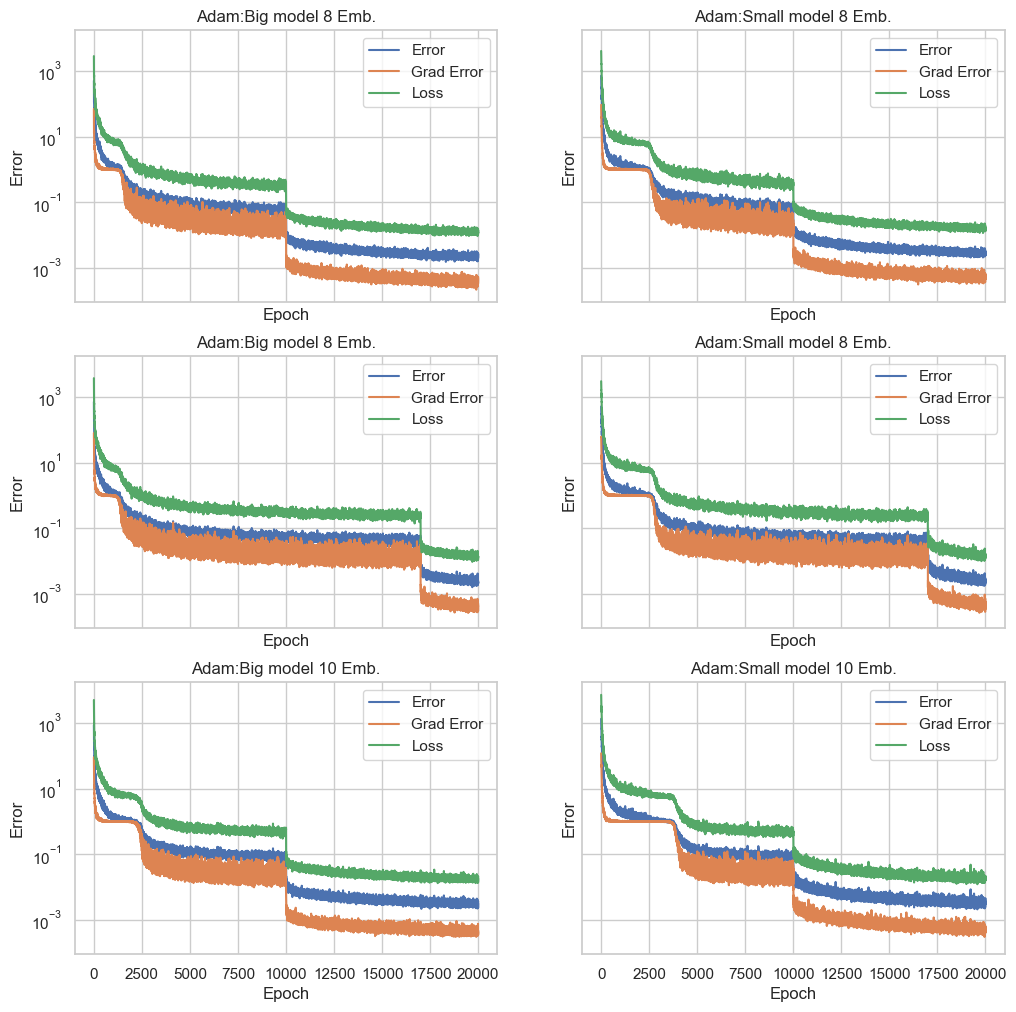

In [12]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_eigenfunc_Adam_17000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/10 emb_[20, 20, 20, 20]_eigenfunc_Adam_10000",

]
title_list = ["Adam:Big model 8 Emb." , "Adam:Small model 8 Emb.",
            "Adam:Big model 8 Emb." , "Adam:Small model 8 Emb.",
            "Adam:Big model 10 Emb." , "Adam:Small model 10 Emb."]

plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

## Inhomogeneous Boundary condition

The solution \( u(x, y) \) for the Poisson equation
\begin{equation}
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -2 ( y (1 - y) + x (1-x))
\end{equation}

with the boundary condition

\begin{equation}
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 5
\end{equation}

has analytical solution:

\begin{equation}
u(x, y) = x (1-x) y (1 - y)  + 5
\end{equation}



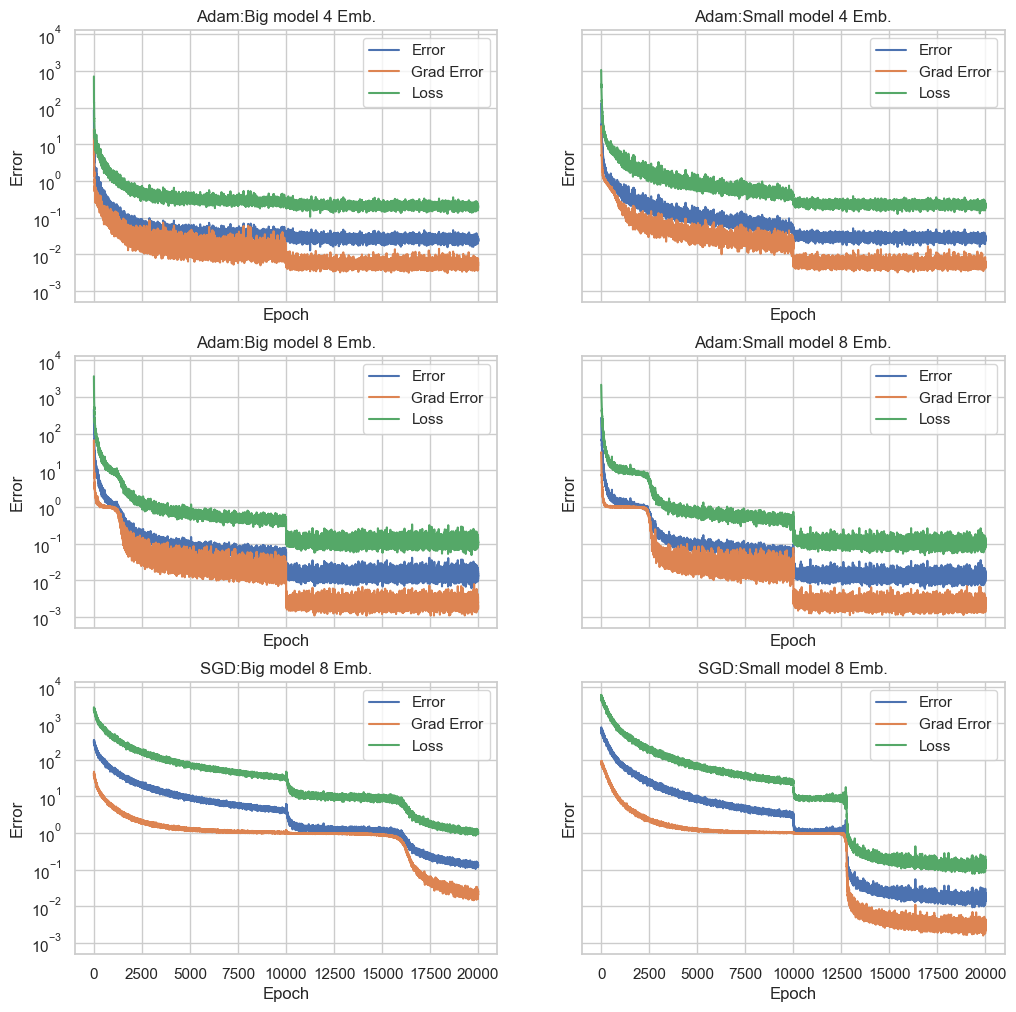

In [13]:
path_list = [
    "../simulation_studies/model_v1_simulation/outputs/4 emb_[64, 64, 64, 64, 64, 64]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/4 emb_[20, 20, 20, 20]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_poly_Adam_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_poly_SGD_10000",
    "../simulation_studies/model_v1_simulation/outputs/8 emb_[20, 20, 20, 20]_poly_SGD_10000",

]
title_list = [
            "Adam:Big model 4 Emb." , "Adam:Small model 4 Emb.",
            "Adam:Big model 8 Emb." , "Adam:Small model 8 Emb.",
            "SGD:Big model 8 Emb." , "SGD:Small model 8 Emb."]

plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

Not good enough!

## Second method: Weakly enforcing boundary conditions

Another option is enforcing the boundary condition through the loss function.
$$ \mathcal{L}(x, y, x_B, y_B) = MSE(\Delta\hat{u}(x, y), f(x,y)) + w MSE(\hat{u}(x_B, y_B), B_{DC}\hat{u}(x_B, y_B))$$
where $w \in \mathbb{R}$ is a measure of the important we give to enforcing the boundary conditon.

#### Strongly Enforcing Boundary Condition

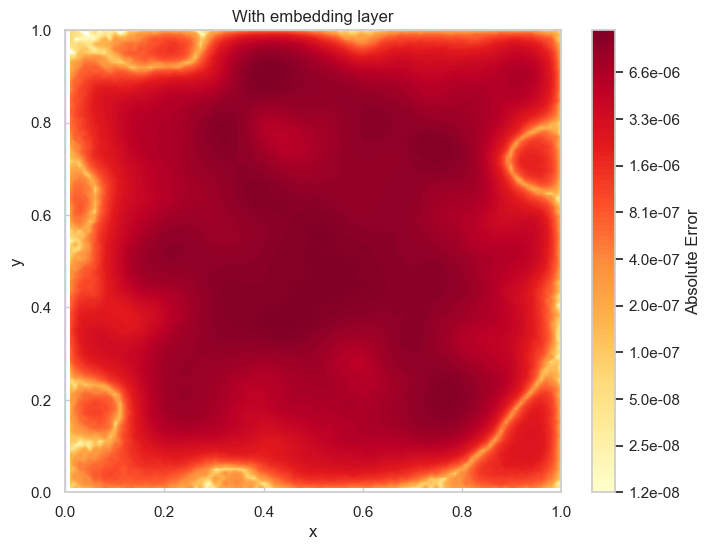

In [14]:
path_to_model_dir = "../simulation_studies/model_v1_simulation/outputs/8 emb_[64, 64, 64, 64, 64, 64]_eigenfunc_Adam_5000"
plot_model_vs_analytical_error(path_to_model_dir, title="With embedding layer")

#### Weakly enforcing Boundary Conditions

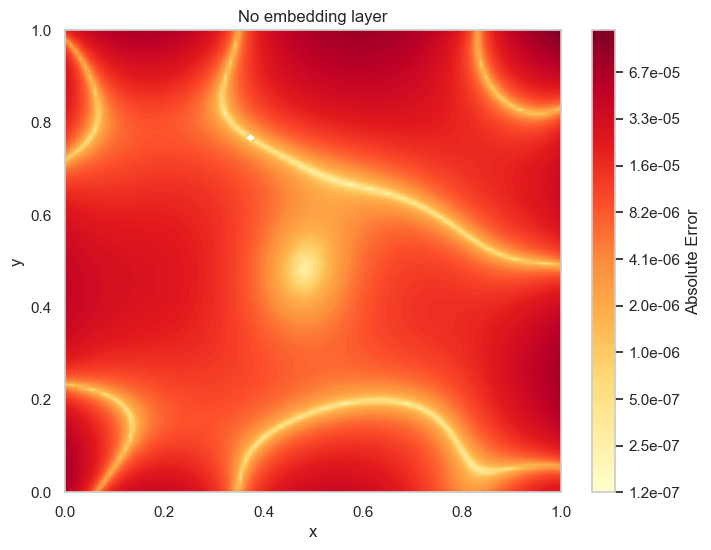

In [15]:
path_to_model_dir = "../simulation_studies/composite_loss_simulation/outputs/30 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_eigenfunc"
plot_model_vs_analytical_error(path_to_model_dir, title="No embedding layer")

### Weakly enforcing boundary condition on the eigenfunction problem

I will try to solve the following poisson problem
\begin{equation}
\Delta u = f(x, y)
\end{equation}

with boundary conditions:

\begin{equation}
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0
\end{equation}

where

\begin{equation}
f(x, y) = -\sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

Clear the analytical solution to this is
\begin{equation}
u(x, y) = \frac{1}{2 \pi^2} \sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

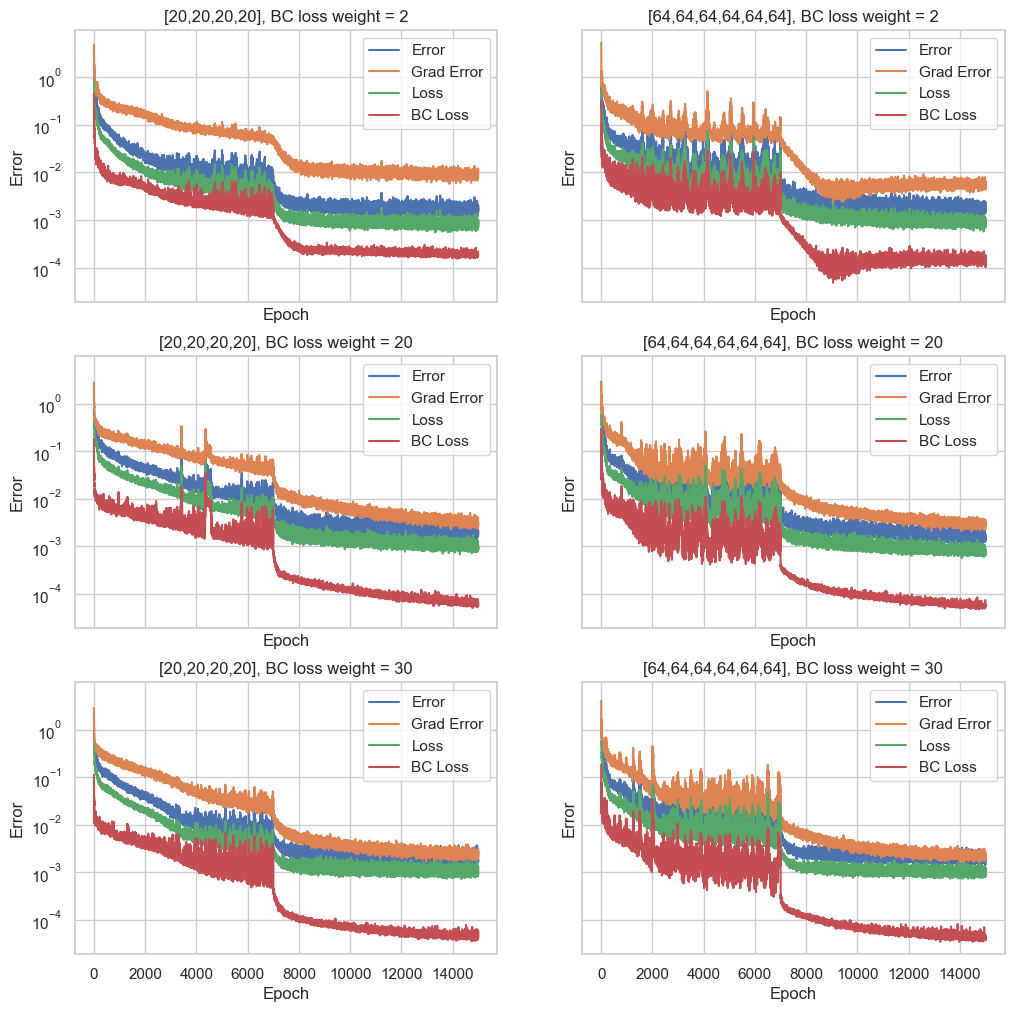

In [16]:
path_list = [
    "../simulation_studies/composite_loss_simulation/outputs/2 weight_[20, 20, 20, 20]_Adam_7000_eigenfunc",
     "../simulation_studies/composite_loss_simulation/outputs/2 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_eigenfunc",
     "../simulation_studies/composite_loss_simulation/outputs/20 weight_[20, 20, 20, 20]_Adam_7000_eigenfunc",
     "../simulation_studies/composite_loss_simulation/outputs/20 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_eigenfunc",
     "../simulation_studies/composite_loss_simulation/outputs/30 weight_[20, 20, 20, 20]_Adam_7000_eigenfunc",
     "../simulation_studies/composite_loss_simulation/outputs/30 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_eigenfunc",

]
title_list = ["[20,20,20,20], BC loss weight = 2", "[64,64,64,64,64,64], BC loss weight = 2", 
              "[20,20,20,20], BC loss weight = 20", "[64,64,64,64,64,64], BC loss weight = 20",
              "[20,20,20,20], BC loss weight = 30", "[64,64,64,64,64,64], BC loss weight = 30",]

plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

Looks much more promissing. I chose the second method. With this in mind I was able to try to solve other PDEs. Ultimately it turn out that the eigenfunction problem was the hardest to solve! The results only get better from here!

## More PDEs

### Constant source term with complicated boundary condition

The solution \( u(x, y) \) for the Poisson equation
\begin{equation}
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 4
\end{equation}

with the boundary condition

\begin{equation}
u(x, y) = x^2 + y^2
\end{equation}

has analytical solution:

\begin{equation}
u(x, y) = x^2 + y^2
\end{equation}



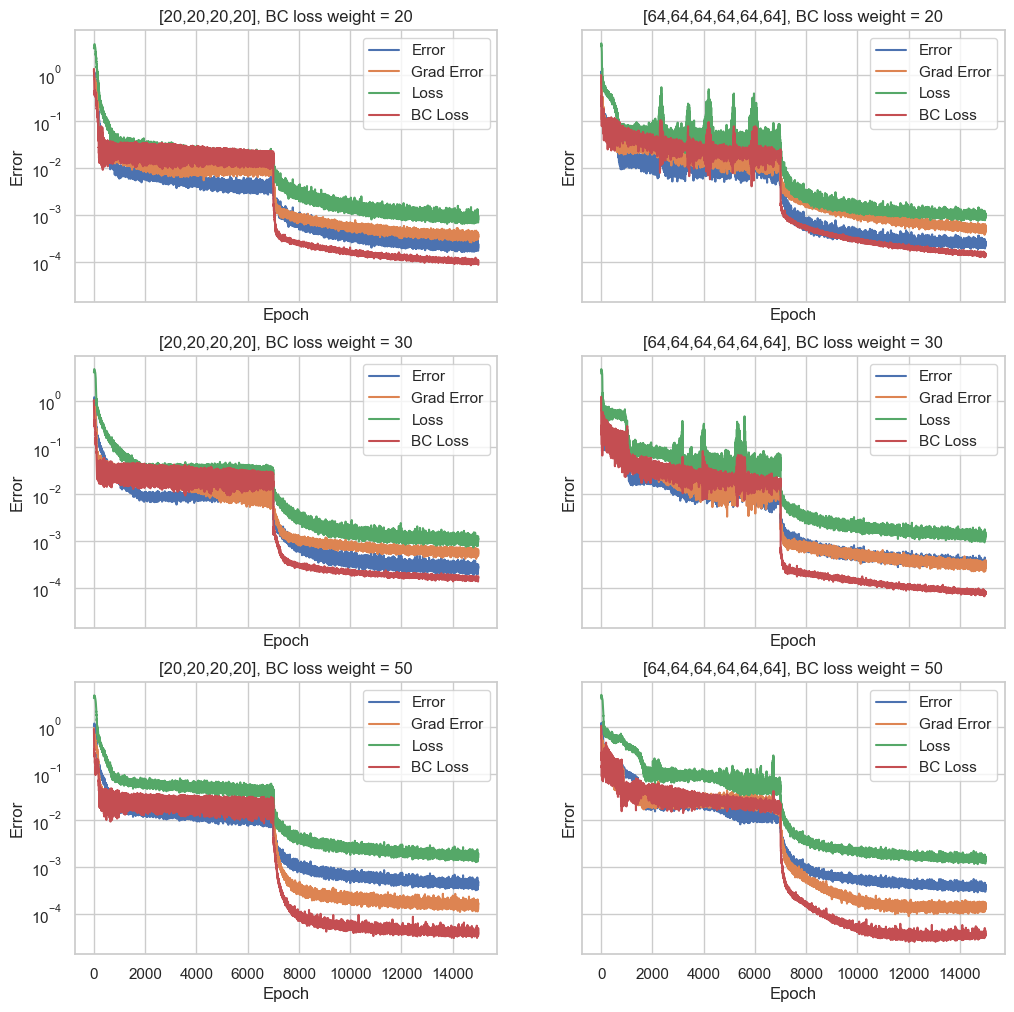

In [17]:
path_list = [
     "../simulation_studies/composite_loss_simulation/outputs/20 weight_[20, 20, 20, 20]_Adam_7000_const_source",
     "../simulation_studies/composite_loss_simulation/outputs/20 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_const_source",
     "../simulation_studies/composite_loss_simulation/outputs/30 weight_[20, 20, 20, 20]_Adam_7000_const_source",
     "../simulation_studies/composite_loss_simulation/outputs/30 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_const_source",
     "../simulation_studies/composite_loss_simulation/outputs/50 weight_[20, 20, 20, 20]_Adam_7000_const_source",
     "../simulation_studies/composite_loss_simulation/outputs/50 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_const_source",

]
title_list = [
              "[20,20,20,20], BC loss weight = 20", "[64,64,64,64,64,64], BC loss weight = 20",
              "[20,20,20,20], BC loss weight = 30", "[64,64,64,64,64,64], BC loss weight = 30",
              "[20,20,20,20], BC loss weight = 50","[64,64,64,64,64,64], BC loss weight = 50"]

plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

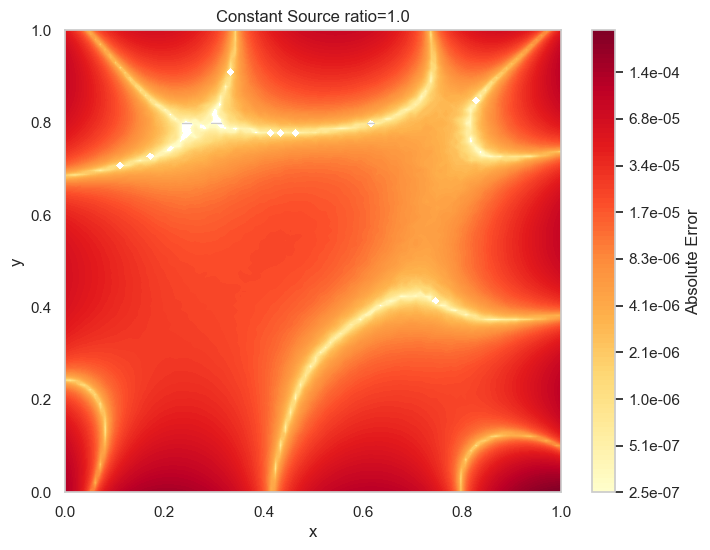

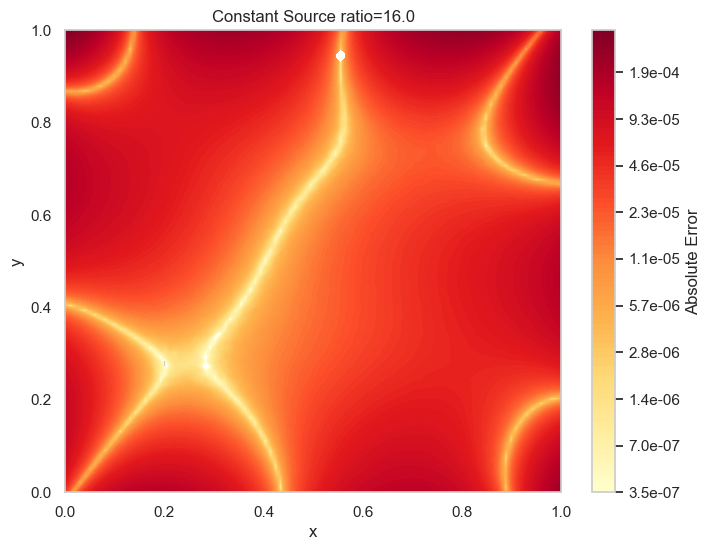

In [18]:
for ratio in [1.0, 16.0]:
    show_abs_error(ratio, "const_source", title="Constant Source")

### Non-constant diffusion matrix

The solution \( u(x, y) \) for the Poisson equation
\begin{equation}
\nabla \cdot (k(x,y) \nabla u(x,y)) = f(x,y)
\end{equation}
with 

\begin{equation}
k(x,y) = \begin{pmatrix}
x + 2 & xy^2\\
xy^2 & y + 3
\end{pmatrix}
\end{equation}

and

\begin{equation}
f(x,y) = 3y^4+9y^2+4x^2y+18y+4x+4
\end{equation}



with the boundary condition

\begin{equation}
u(x,y)=x^2+y^3
\end{equation}


has analytical solution:

\begin{equation}
u(x, y) = x^2+y^3
\end{equation}



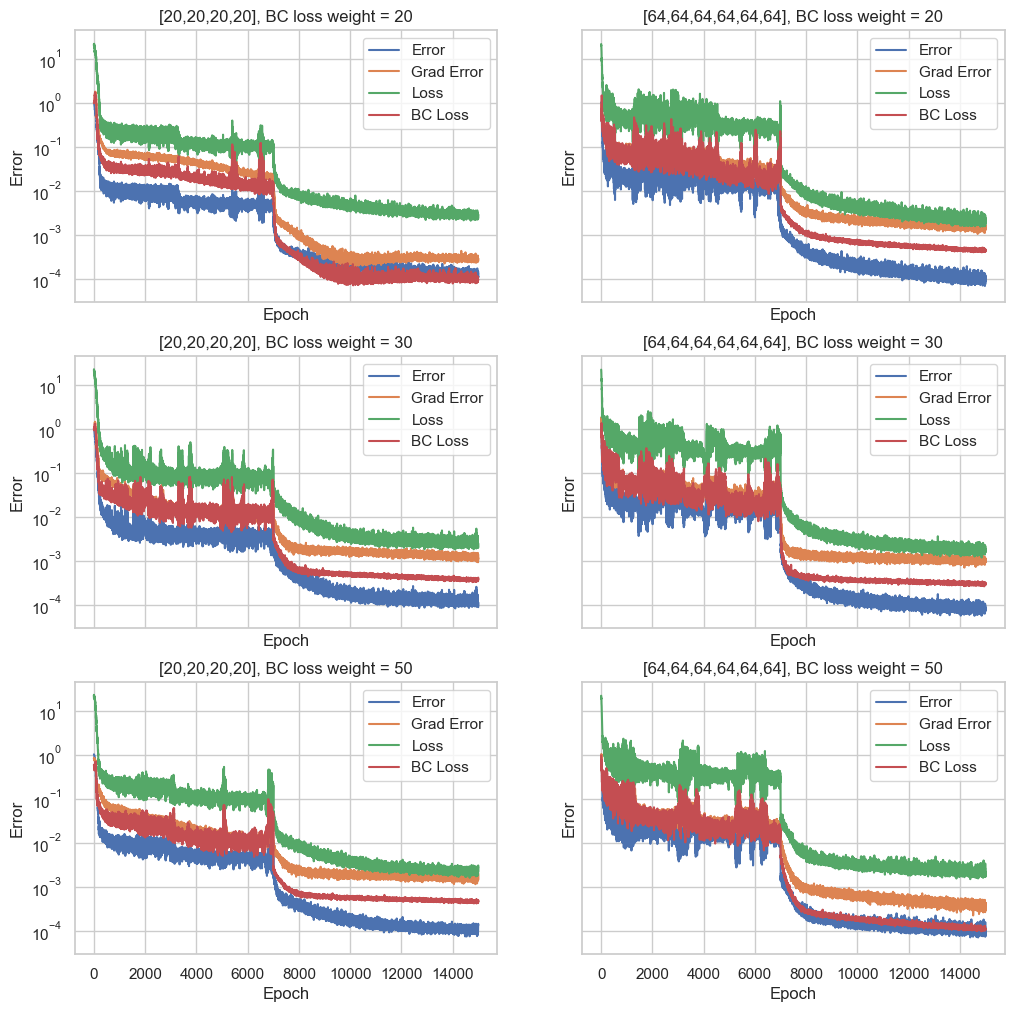

In [19]:
path_list = [
     "../simulation_studies/composite_loss_simulation/outputs/20 weight_[20, 20, 20, 20]_Adam_7000_non_const_BC",
     "../simulation_studies/composite_loss_simulation/outputs/20 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_non_const_BC",
     "../simulation_studies/composite_loss_simulation/outputs/30 weight_[20, 20, 20, 20]_Adam_7000_non_const_BC",
     "../simulation_studies/composite_loss_simulation/outputs/30 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_non_const_BC",
     "../simulation_studies/composite_loss_simulation/outputs/50 weight_[20, 20, 20, 20]_Adam_7000_non_const_BC",
     "../simulation_studies/composite_loss_simulation/outputs/50 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_non_const_BC",

]
title_list = [ 
              "[20,20,20,20], BC loss weight = 20", "[64,64,64,64,64,64], BC loss weight = 20",
              "[20,20,20,20], BC loss weight = 30", "[64,64,64,64,64,64], BC loss weight = 30",
              "[20,20,20,20], BC loss weight = 50","[64,64,64,64,64,64], BC loss weight = 50"]

plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=2, title_list=title_list)

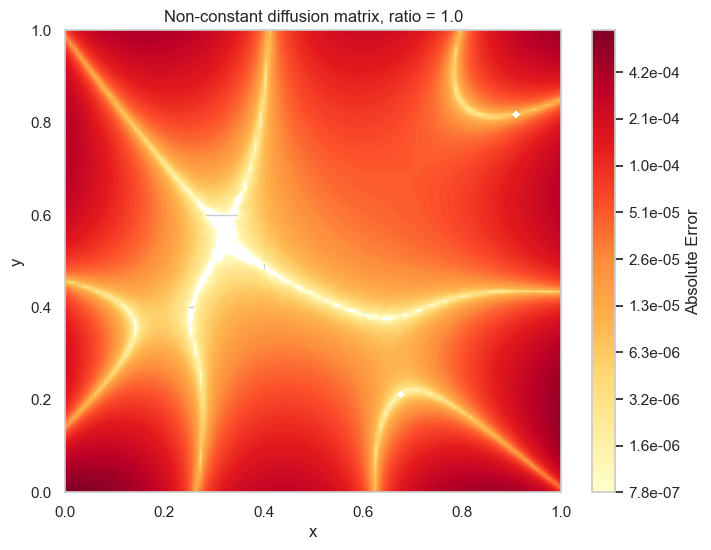

In [20]:
path_to_model_dir = "../simulation_studies/composite_loss_simulation/outputs/30 weight_[64, 64, 64, 64, 64, 64]_Adam_7000_non_const_BC"
plot_model_vs_analytical_error(path_to_model_dir, title="Non-constant diffusion matrix, ratio = 1.0")   

### Piecewise diffusion matrix

The solution \( u(x, y) \) for the Poisson equation
\begin{equation}
\nabla \cdot (k(x,y) \nabla u(x,y)) = f(x,y)
\end{equation}
with 

\begin{equation}
k(x,y) =
\begin{cases}
\begin{pmatrix}
x^3 + 5 & x + y \\
x + y & y^2 + 7
\end{pmatrix}
\quad \text{for} \quad x <= 0.5
\\
\begin{pmatrix}
-x^2 + 2 & -xy \\
-xy & -y^3-3
\end{pmatrix}
\quad \text{for} \quad x > 0.5\\
\end{cases}
\end{equation}

and


\begin{equation}
f(x,y) = \begin{cases}
15x^4 + 3x^2y+33x + y + 3x^2 -6y^2+2xy-14
\quad \text{for} \quad x <= 0.5
\\
-(12x^3 + 6xy -12x -2y^2 + 3x^3 -8y^3+3y^2x -6)
\quad \text{for} \quad x > 0.5\\
\end{cases}
\end{equation}



with the boundary condition

\begin{equation}
u(x,y)=x^3 - y^2 + xy
\end{equation}


has analytical solution:

\begin{equation}
u(x, y) = x^3 - y^2 + xy
\end{equation}



In [21]:
import hmpinn
piecewise_poi_eq = PiecewiseDiffusion()

In [22]:
x = torch.tensor([[0.5, 0.6]], requires_grad=True)
print("x <= 0.5")
print(piecewise_poi_eq.diffusion_matrix(x))
print(piecewise_poi_eq.f(x))

x = torch.tensor([[0.5000001, 0.6]], requires_grad=True)
print("x > 0.5")
print(piecewise_poi_eq.diffusion_matrix(x))
print(piecewise_poi_eq.f(x))

x <= 0.5
tensor([[[5.1250, 1.1000],
         [1.1000, 7.3600]]], grad_fn=<WhereBackward0>)
tensor([3.6775], grad_fn=<WhereBackward0>)
x > 0.5
tensor([[[ 1.7500, -0.3000],
         [-0.3000, -3.2160]]], grad_fn=<WhereBackward0>)
tensor([10.2330], grad_fn=<WhereBackward0>)


In [23]:
# Prepare a model to training
model_piecewise = ModelV0(piecewise_poi_eq, [64, 64, 64, 64, 64], False)

In [24]:
# Training
errors, grad_errors, losses, BC_losses = train(model_piecewise, 
                                                      batch_size=128, 
                                                      n_epochs=5000, 
                                                      optimizer="SGD", 
                                                      optimizer_threshold=4500, 
                                                      loss_BC_weight=15, 
                                                      save_BC_loss=True, 
                                                      seed=10)

Using Cuda
Solving the PDE: PiecewiseDiffusion(backend=torch)


100%|██████████| 500/500 [07:48<00:00,  1.07it/s]


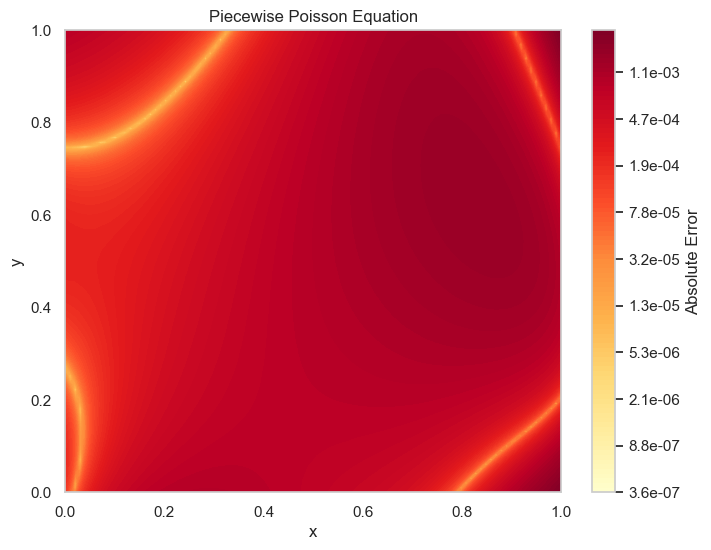

In [25]:
plot_model_vs_analytical_error(model_piecewise, "Piecewise Poisson Equation")

# Non-divergence form PDEs

## Eigenfunction problem

In divergence form the eigenfunction equaiton is

I will try to solve the following poisson problem
\begin{equation}
\Delta u = f(x, y)
\end{equation}

with boundary conditions:

\begin{equation}
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0
\end{equation}

where

\begin{equation}
f(x, y) = -\sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

Clear the analytical solution to this is
\begin{equation}
u(x, y) = \frac{1}{2 \pi^2} \sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

In [26]:
eigenfunction_divergence_form = EigenfunctionSourceDF()
eigenfunction_divergence_form.is_in_divergence_form

True

In non-divergence form it is of the kind

$$A(x,y):H(x,y) = f(x,y)$$

Where
\begin{equation}
A(x, y) = \begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}
\end{equation}

and
\begin{equation}
H(x, y) = \begin{pmatrix}
\frac{\partial^2 u}{\partial x^2} & \frac{\partial^2 u}{\partial x \partial y} \\
\frac{\partial^2 u}{\partial y \partial x} & \frac{\partial^2 h}{\partial y^2}
\end{pmatrix}
\end{equation}


With 

\begin{equation}
f(x, y) = -\sin\left(\pi x\right) \sin\left(\pi y\right)
\end{equation}

In [27]:
eigenfunction_non_divergence_form = EigenfunctionSourceNonDF()
eigenfunction_non_divergence_form.is_in_divergence_form

False

### Training

In [28]:
torch.manual_seed(0)
model_div_form =  ModelV0(eigenfunction_divergence_form, has_embedding_layer=False)
torch.manual_seed(0)
model_non_div_form =  ModelV0(eigenfunction_non_divergence_form, has_embedding_layer=False)

In [29]:
errors, grad_errors, loss, BC_loss = train(model_div_form, n_epochs=200, seed=0, optimizer_threshold=150, save_BC_loss=True)

Using Cuda
Solving the PDE: EigenfunctionSourceDF(a=1, b=1, amplitude=1, backend=torch)


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


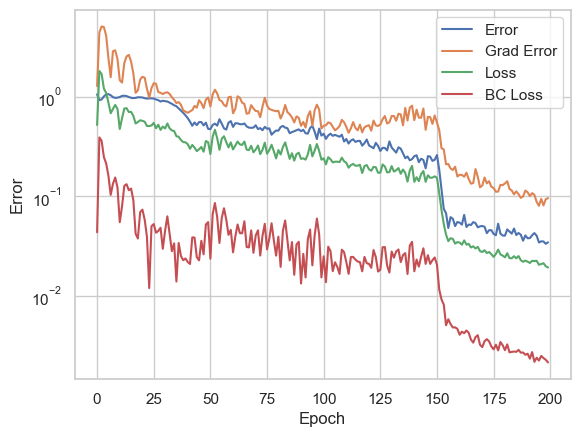

In [30]:
plot_errors_from_data(errors, grad_errors, loss, BC_loss)

In [31]:
errors, grad_errors, loss, BC_loss = train(model_non_div_form, n_epochs=200, seed=0, optimizer_threshold=150, save_BC_loss=True)

Using Cuda
Solving the PDE: EigenfunctionSourceNonDF(a=1, b=1, backend=torch)


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


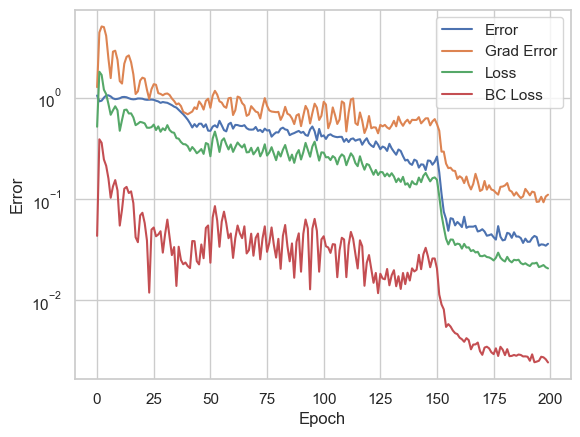

In [32]:
plot_errors_from_data(errors, grad_errors, loss, BC_loss)

## Side note on the activation function

For all the graphs above the models had tanh activate function, however recently I discovered that the GeLU activation function may work better

The solution \( u(x, y) \) for the Poisson equation
\begin{equation}
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 4
\end{equation}

with the boundary condition

\begin{equation}
u(x, y) = x^2 + y^2
\end{equation}

has analytical solution:

\begin{equation}
u(x, y) = x^2 + y^2
\end{equation}



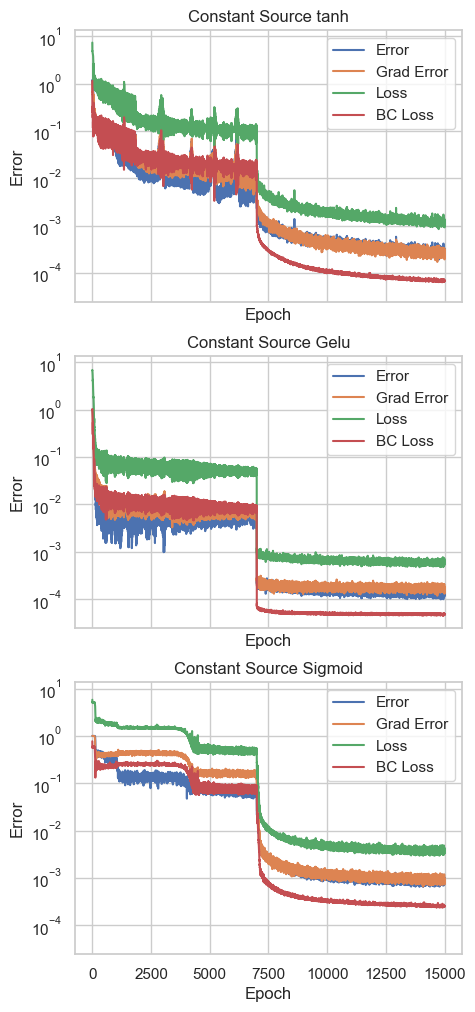

In [33]:
path_list = [
    "../simulation_studies/weakly_enforcing_BC/outputs/8.0_const_source_tanh",
    "../simulation_studies/weakly_enforcing_BC/outputs/8.0_const_source_gelu",
    "../simulation_studies/weakly_enforcing_BC/outputs/8.0_const_source_sigmoid",
]
title_list = ["Constant Source tanh", "Constant Source Gelu", "Constant Source Sigmoid"]
plot_errors_in_grid(path_list, number_of_rows=3, number_of_columns=1, title_list=title_list)

# What's next?

- With a functional PINN the next goal is to start solving PDEs that do not have an analytical solution
- Compare with a benchmark spline solver

Thank you!